# mshap

<!-- badges: start -->
[![codecov](https://codecov.io/gh/Diadochokinetic/mshap/graph/badge.svg?token=I8WXLLYC4I)](https://codecov.io/gh/Diadochokinetic/mshap)
<!-- badges: end -->

This is a Python port of [srmatth/mshap](https://github.com/srmatth/mshap)

The goal of mshap is to allow SHAP values for two-part models to be
easily computed. A two-part model is one where the output from one model
is multiplied by the output from another model. These are often used in
the Actuarial industry, but have other use cases as well.

## Installation

Install mSHAP from pypi with the following code:

``` sh
pip install mshap
```

Or the development version from github with:

``` sh
pip install git+https://github.com/Diadochokinetic/mshap
```


## Basic Use

We will demonstrate a simple use case on simulated data. Suppose that we wish to be able to predict to total amount of money a consumer will spend on a subscription to a software product. We might simulate 4 explanatory variables that looks like the following:

In [1]:
import numpy as np

age = np.random.uniform(18, 60, size=1000)
income = np.random.uniform(50000, 150000, size=1000)
married = np.random.randint(0, 2, size=1000)
sex = np.random.randint(0, 2, size=1000)

Now because this is a contrived example, we will knowingly set the
response variables as follows (suppose here that `cost_per_month` is
usage based, so as to be continuous):

In [2]:
cost_per_month = (0.0006 * income - 0.2 * sex + 0.5 * married - 0.001 * age) + 10
num_months = 15 * (0.001 * income * 0.001 * sex * 0.5 * married - 0.05 * age) ** 2

Thus, we have our data. We will combine the covariates and target variables into a single
data frame for ease of use in python.

In [3]:
import pandas as pd

data = pd.DataFrame(
    {
        "age": age,
        "income": income,
        "married": married,
        "sex": sex,
        "cost_per_month": cost_per_month,
        "num_months": num_months,
    }
)

The end goal of this exercise is to predict the total revenue from the given customer, which mathematically will be `cost_per_month * num_months`. Instead of multiplying these two vectors together initially, we will instead create two models: one to predict `cost_per_month` and the other to predict `num_months`. We can then multiply the output of the two models together to get our predictions.

We now create our two models and predict on the training sets:

In [4]:
from sklearn.ensemble import RandomForestRegressor

X = data[["age", "income", "married", "sex"]]
y1 = data["cost_per_month"]
y2 = data["num_months"]

cpm_mod = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=2)
cpm_mod.fit(X, y1)
# > RandomForestRegressor(max_depth=10, max_features=2)
nm_mod = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=2)
nm_mod.fit(X, y2)
# > RandomForestRegressor(max_depth=10, max_features=2)
cpm_preds = cpm_mod.predict(X)
nm_preds = nm_mod.predict(X)

tot_rev = cpm_preds * nm_preds

We will now proceed to use TreeSHAP and subsequently mSHAP to explain the ultimate model predictions.

In [5]:
import shap

cpm_ex = shap.Explainer(cpm_mod)
cpm_shap = cpm_ex.shap_values(X)
cpm_expected_value = cpm_ex.expected_value

nm_ex = shap.Explainer(nm_mod)
nm_shap = nm_ex.shap_values(X)
nm_expected_value = nm_ex.expected_value

In [6]:
from mshap import Mshap

final_shap = Mshap(
    cpm_shap, nm_shap, cpm_expected_value, nm_expected_value
).shap_values()
final_shap

`ex1` has a length greater than 1, only using first element
`ex2` has a length greater than 1, only using first element


{'shap_vals':                0            1          2           3
 0    2304.593163  1362.327283  39.905727   50.587857
 1    -526.277320 -1385.947293   6.497397   30.161198
 2    3245.072955  -786.997131 -24.045209  -33.677650
 3    1143.807878  1675.503032 -30.717164  -96.052152
 4   -3758.632773  1008.158432  38.286881  -14.098981
 ..           ...          ...        ...         ...
 995  2644.092843  1950.651210 -28.989649 -131.300562
 996  1458.186452  1256.890955 -61.646588  -93.603007
 997  3772.872599   887.335694  59.240506  -37.987820
 998 -1603.493335   628.941902  42.466157  -40.868031
 999  2238.547899  -336.345192 -36.113203  -84.435878
 
 [1000 rows x 4 columns],
 'expected_value': 4414.0647689693105}

You can put the result into a shap Explanation object to use shap plot capabilities:


In [10]:
final_shap_explanation = shap.Explanation(
    values=final_shap["shap_vals"].values,
    base_values=final_shap["expected_value"],
    data=X,
    feature_names=X.columns,
)

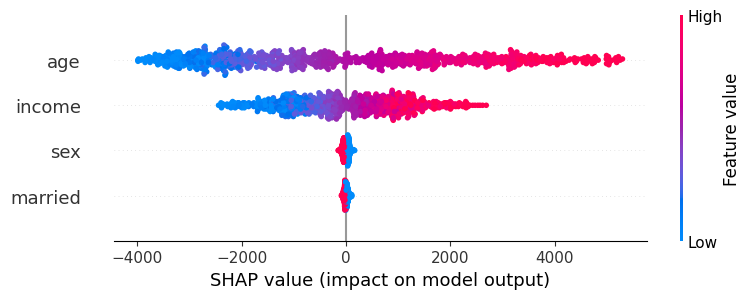

In [11]:
shap.summary_plot(final_shap_explanation, X)

## Citations

-   For more information about SHAP values in general, you can visit the[SHAP github page](https://github.com/slundberg/shap)
-   If you use `{mshap}`, please cite [*mSHAP: SHAP Values for Two-Part Models*](https://arxiv.org/abs/2106.08990)